<a href="https://colab.research.google.com/github/JanSchering/Thesis/blob/main/ABC_Notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title install dependencies
!pip install tqdm
!pip install --upgrade -q git+https://github.com/google/flax.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 145 kB 7.3 MB/s 
     |████████████████████████████████| 8.1 MB 42.7 MB/s 
     |████████████████████████████████| 237 kB 57.0 MB/s 
     |████████████████████████████████| 51 kB 7.5 MB/s 
     |████████████████████████████████| 85 kB 4.4 MB/s 


In [13]:
# @title imports
from typing import Callable, List, Tuple
import jax.numpy as jnp
from jax import lax
from jax import grad
import numpy as np
import matplotlib.pyplot as plt
import random
from IPython.display import Image
from IPython import display
from tqdm import tqdm
import time

# Approximate Bayesian Computation

**Given:**

- Set of observations $x \in \mathcal{X}$, generated by a Data generating Process
- The process can be described via a parametric likelihood with a probability density function (PDF) $f(x|\theta)$, $\theta \in \mathcal{R}^d$
- A prior probability distribution over $\theta$: $\pi(\theta)$

**Goal:**

Describe/Approximate the posterior distribution:

$$
\pi(\theta|x) = \frac{f(x|\theta)\pi(\theta)}{\int_{\theta \in \mathcal{R}^d} f(x|\theta)\pi(\theta)d\theta} \tag{1}
$$

⟹ If the likelihood function is not known or intractable, we cannot sample from (1) efficiently or at all. Instead, we want to draw samples from a sufficiently good approximation of (1). We can obtain these samples via *Approximate Bayesian Computation (ABC)*.

**General Approach:**

1. Define Pseudo-Posterior
2. Draw a candidate parameter vector $\theta^*$
3. generate a dataset $x^* \sim f(x|\theta^*)$
4. Accept candidate if $x^*$ is "close" enough to $x$ 
    - "Close" is defined as the distance $\rho(x^*, x)$ being smaller than a tolerance threshold $𝜀$

## Approximate Bayesian computation via rejection sampling (ABC-REJ)

1. Generate $\theta^* \sim \pi(\theta)$
2. Generate $x^* \sim f(x|\theta^*)$
3. Accept $\theta^*$ if $\rho(S(x^*), S(x)) <= \epsilon$, S(.) being the summary statistics of the dataset.
4. If rejected, return to 1.

⟶ Each accepted vector $\theta^*$ is an independent sample drawn from $f(\theta|\rho(S(x), S(x_0)) \leq \epsilon)$. If the statistics $S$ are near-sufficient and $\epsilon$ sufficiently small, $f(\theta|\rho(S(x), S(x_0)) \leq \epsilon)$ becomes a reasonable approximation of the posterior.

### Example

Taken from [this paper](https://www.pnas.org/doi/pdf/10.1073/pnas.0607208104). Let the desired posterior be defined by the likelihood function:

$$
f(\theta|x_0) = \frac{1}{2} \phi(0,\frac{1}{100}) + \frac{1}{2}\phi(0,1)
$$

where $\phi(\mu,\sigma^2)$ is the density function of a normal distribution $N(\mu,\sigma^2)$. We define the prior $\pi(\theta)=U(-10,10)$. Further, let $\epsilon=0.025$ and the distance function be defined as:

$$
\rho(x_{sim}, x_{obs}) = 
\begin{cases}
  |\bar{x}| \text{with probability} \frac{1}{2}, \\
  |x_1| \text{with probability} \frac{1}{2} 
\end{cases}
$$

$x^*$ is generated by a normal distribution parameterized by the candidate $\theta^*$:

$$
x^* \sim \mathcal{N}(\theta^*,1)
$$


In [ ]:
# @title Helper functions
def gaussian_pdf(mu:float, sigma_sq:float) -> Callable:
  def pdf(x:float) -> float:
    return (1/(np.sqrt(2*np.pi)*np.sqrt(sigma_sq)))*np.exp(-(x-mu)**2/(2*sigma_sq))
  return pdf

# note: The distance function would usually depend on the original dataset as well.
# Not necessary in this case as the mean of the original dataset should simply be 0.
# Distance function as defined in the paper.
def calc_distance(x_sim:np.ndarray) -> float:
  if random.random() > 0.5:
    return np.abs(np.mean(x_sim))
  else:
    return np.abs(x_sim[0])

# The paper defines a uniform prior 
def sample_from_prior(num_samples:int) -> np.ndarray:
  return np.random.uniform(-10, 10, num_samples)

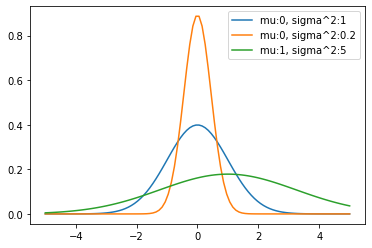

In [ ]:
# @title Tests { vertical-output: true}
pdf_1 = gaussian_pdf(0,1)
pdf_2 = gaussian_pdf(0,0.2)
pdf_3 = gaussian_pdf(1,5)

xs = np.linspace(-5,5,100)

plt.plot(xs, [pdf_1(x) for x in xs], label="mu:0, sigma^2:1")
plt.plot(xs, [pdf_2(x) for x in xs], label="mu:0, sigma^2:0.2")
plt.plot(xs, [pdf_3(x) for x in xs], label="mu:1, sigma^2:5")
plt.legend()

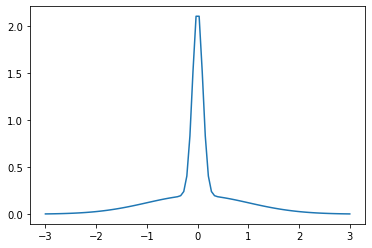

In [ ]:
# @title Define and visualize the posterior { vertical-output: true}
pdf_1 = gaussian_pdf(0,1/100)
pdf_2 = gaussian_pdf(0,1)

def posterior(theta:float) -> float:
  return (1/2)*pdf_1(theta) + (1/2)*pdf_2(theta)

thetas = np.linspace(-3,3,100)

plt.plot(thetas, [posterior(theta) for theta in thetas])

In [ ]:
# @title define ABC-REJ 
epsilon = 0.025

def ABC_REJ() -> float:
  num_steps = 1
  theta = None
  while True:
    theta = sample_from_prior(1)
    x_sim = np.random.normal(theta, 1, 100)
    distance = calc_distance(x_sim)
    if distance <= epsilon:
      break
    else:
      num_steps += 1
  return theta, num_steps

100%|██████████| 1000/1000 [00:17<00:00, 58.71it/s]


average # steps for acceptance: 396.688


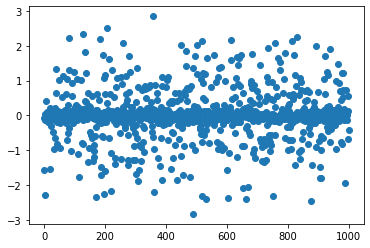

In [ ]:
# @title use ABC-REJ to draw approximate samples from the posterior  { vertical-output: true}

samples = []
required_steps = []

# In the paper, 1,000 accepted samples are drawn
for i in tqdm(range(1000)):
  sample, num_steps = ABC_REJ()
  samples.append(sample)
  required_steps.append(num_steps)

print(f"average # steps for acceptance: {np.mean(required_steps)}")

plt.scatter(np.arange(len(samples)), samples)


## Approximate Bayesian computation via Markov-Chain Monte-Carlo (ABC-MCMC)

1. Initialize $\theta_1, i=1$
2. Generate $\theta^* \sim q(\theta|\theta_i)$, from an arbitrary proposal density $q$
3. Generate $x^* \sim f(x|\theta^*)$
4. Set $\theta_{i+1}=\theta^*$ with the following probability:

$$
\alpha = \min \begin{cases} 1, \frac{\pi(\theta^*)q(\theta_i|\theta^*)}{\pi(\theta_i)q(\theta^*|\theta_i)} \textbf{1}(\rho(S(x_{sim}), S(x_{obs})) \leq \epsilon) \end{cases}
$$

Set $\theta_{i+1}=\theta_{i}$ otherwise.

Here, $\textbf{1}(A)$ is true if the statement $A$ evaluates to $True$, 0 otherwise.

### Example

We use the same toy example as for ABC-REJ, taken from [this paper](https://www.pnas.org/doi/pdf/10.1073/pnas.0607208104). Let the desired posterior be defined by the likelihood function:

$$
f(\theta|x_0) = \frac{1}{2} \phi(0,\frac{1}{100}) + \frac{1}{2}\phi(0,1)
$$

where $\phi(\mu,\sigma^2)$ is the density function of a normal distribution $N(\mu,\sigma^2)$. 

****

For ABC-MCMC, we define $\theta_0=0$, $N=10,000$ iterations and $\epsilon=0.025$. The proposal density function is defined as a random walk $q(\theta|\theta_t) \sim \mathcal{N}(\theta_t, 0.15^2)$. The simulated dataset $x^*$ consists of 100 samples drawn from a normal distribution, $x^* \sim \mathcal{N}(\theta,1)$.

The distance function is given by:

$$
\rho(x_{sim}, x_{obs}) =
\begin{cases}
  |\bar{x}| \text{with probability} \frac{1}{2}, \\
  |x_1| \text{with probability} \frac{1}{2} 
\end{cases} 
$$

In [135]:
# @title Helper Functions
def gaussian_pdf(mu:float, sigma_sq:float) -> Callable:
  def pdf(x:float) -> float:
    return (1/(np.sqrt(2*np.pi)*np.sqrt(sigma_sq)))*np.exp(-(x-mu)**2/(2*sigma_sq))
  return pdf

def q(mu:float, sigma:float) -> float:
  return np.random.normal(mu, sigma)

def calc_distance(x_sim:np.ndarray) -> float:
  if random.random() > 0.5:
    return np.abs(np.mean(x_sim))
  else:
    return np.abs(x_sim[0])

def gauss_likelihood(x, y, sigma) -> float:
  pdf = gaussian_pdf(y, sigma)
  return pdf(x)

def calc_alpha(theta_star:float, theta:float, epsilon:float, dist:float, sigma:float) -> float:
  if dist <= epsilon:
    return min([1,gauss_likelihood(theta, theta_star, sigma)/gauss_likelihood(theta_star, theta, sigma)])
  else:
    return 0


In [136]:
# @title Define ABC-MCMC
def ABC_MCMC(N:int, epsilon:float, theta:float, proposal_sigma:float) -> List[float]:
  thetas = [theta]
  for i in tqdm(range(N)):
    theta_star = q(theta, proposal_sigma)
    x_sim = np.random.normal(theta_star, 1, 100)
    dist = calc_distance(x_sim)
    alpha = calc_alpha(theta_star, theta, epsilon, dist, proposal_sigma)
    if random.random() <= alpha:
      theta = theta_star
    thetas.append(theta)
  return thetas

100%|██████████| 10000/10000 [00:00<00:00, 58481.73it/s]


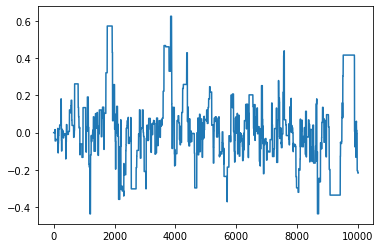

In [137]:
# @title Run ABC-MCMC for the example { vertical-output: true}
N = 10_000
epsilon = 0.025
theta_init = 0
proposal_sigma = 0.15

thetas = ABC_MCMC(N, epsilon, theta_init, proposal_sigma_sq)

plt.plot(np.arange(len(thetas)), thetas)

(-4.0, 4.0)

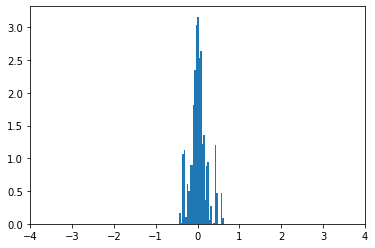

In [138]:
n, bins, _ = plt.hist(thetas, density=True, bins=30)
plt.xlim(-4,4)

## Approximate Bayesian computation via Sequential Monte-Carlo with Particle Rejection Control (ABC-PRC)

**Goal:**

Draw $N$ samples (particles) from the posterior distribution $f(\theta|\rho(S(x_{sim}), S(x_{obs})) \leq \epsilon)$.

**Given:**

- Summary statistics $S(.)$
- Threshold $\epsilon$
- Distance Function $\rho$ 

**Approach:**

1. Define an initial population $\theta^{(1)}, \dots, \theta^{(N)} \sim \mu_1$, with $\mu_1$ being a known distribution we can sample from
2. Define $f_T(\theta) = f(\theta|\rho(S(x_{sim}), S(x_{obs})) \leq \epsilon)$

→ Standard Importance Sampling: Weigh all drawn particles by their importance $W^{(i)}_T = f_T(\theta^{(i)}_1)/\mu_1(\theta^{(i)}_1)$.

****

**Problem 1:** Can fail or become inefficient if there is a mismatch between sampling distribution $\mu_1$ and target distribution $f_T$ 

⟶ Solution (Sequential Sampling): Define a sequence of intermediary distributions $f_1, \dots, f_{T-1}$, gradually moving from $\mu_1$ towards $f_T$. Then iteratively move and reweight the particles in accordance to their adherence to each consecutive distribution $f_t,$ for $t=1,\dots,T$.

In the case of ABC, the sequence of distributions can be defined as:

$$
f_t(\theta|\rho(S(x_{sim}), S(x_{obs})) \leq \epsilon_t) = \frac{\pi(\theta)}{B_t} \sum_{b=1}^{B_t} \textbf{1}(\rho(S(x_{(b)}), S(x_{obs})) \leq \epsilon_t)
$$

with:

- $x_{(1)},\dots, x_{(B_t)}$ being $B_T$ datasets generated with a fixed parameter vector $\theta$, $x_{(b)} \sim f(x|\theta)$
- $\{\epsilon_t\}$ being a strictly decreasing sequence of thresholds

****

**Problem 2:** With this method, the particle weights are directly proportional to the likelihood of the particles. There is a high probability that this likelihood equates to 0. A zero-likelihood means zero weight, which makes the particle useless as it is out of consideration.

⟶ Solution (Particle Rejection Control): Using PRC, we can resample from the previous distribution and move the sampled particles, in order to get a replacement for those particles with zero-weight. We do this replacement step until we have a population of $N$ particles with non-zero weight.

****

**ABC-PRC Algorithm:**

1. Define
  - $\epsilon_1, \dots, \epsilon_T$ 
  - sampling distribution $\mu_1$
  - population indicator $t=1$
2. Set particle indicator $i=1$, then
  1. IF
  - $t == 1$: sample $\theta^{**} \sim \mu_1(\theta)$ independently 
  - $t > 1$: sample $\theta^{*}$ from the prev. population, weighted by their importance $W^{(i)}_{t-1}$, then move the particle to $\theta^{**} \sim K_t(\theta|\theta^*)$ according to a Markov transition kernel $K_t$
  2. Sample $x^{**} \sim f(x|\theta^{**})$
  3. IF $\rho(S(x^{**}), S(x_{obs})) \geq \epsilon_t$, go back to 2.1
  4. Set 
$$
\theta^{(i)}_t = \theta^{**}, W^{(i)}_t = 
\begin{cases}
\pi(\theta^{(i)}_t)/\mu_1(\theta^{(i)}_t) \text{if t==1}, \\
\frac{\pi(\theta^{(i)}_t)L_{t-1}(\theta^*|\theta^{(i)}_t)}{\pi(\theta^*)K_t(\theta^{(i)}_t|\theta^*)} \text{if t>1}
\end{cases}
$$
with $\pi(\theta)$ being the prior distribution and $L_{t-1}$ a backward transition kernel
  5. IF $i < N$, increment $i = i + 1$ then return to 2.1
3. Normalize the weights, such that $\sum_{i=1}^N W^{(i)}_t = 1$
4. Calculate $ESS = [\sum_{i=1}^N (W^{(i)}_t)^2]^{-1}$. IF $ESS < E$, resample the particles $\{\theta^{(i)}_t\}$ with current weights $\{W^{(i)}_t\}$ to get a new population of particles $\{\theta^{(i)}_t\}$. Set the weights of the new population to $\{W^{(i)}_t = 1/N \}$.
5. IF $t < T$, increment $t=t+1$ and return to 2.

NOTE: If $T=1$ and $\mu_1(\theta)=\pi(\theta)$, ABC-PRC is equivalent to ABC-REJ.

****

**Implementation Notes from the paper:**

- In the examples, $K_t(\theta_t|\theta_{t-1})=L(\theta_{t-1}|\theta)$ as a gaussian kernel with common variance
- From $K_t(\theta_t|\theta_{t-1})=L(\theta_{t-1}|\theta)$, $\mu_1(\theta)=\pi(\theta)$, $\pi(\theta) \propto 1$ over the parameters space $\Theta$, follows that all weights are equal during sampling and can be ignored. This also means that for this special case steps 3. and 4. can be ignored

### Example 

We consider the same example from [this paper](https://www.pnas.org/doi/pdf/10.1073/pnas.0607208104). Let the desired posterior be defined by the likelihood function:

$$
f(\theta|x_0) = \frac{1}{2} \phi(0,\frac{1}{100}) + \frac{1}{2}\phi(0,1)
$$

where $\phi(\mu,\sigma^2)$ is the density function of a normal distribution $N(\mu,\sigma^2)$. 

****

For ABC-PRC, we use:

- A population of $N=1000$ particles
- A sequence of three distributions $f_1, f_2, f_3$ defined through:
$$
f_t(\theta|\rho(S(x_{sim}), S(x_{obs})) \leq \epsilon_t) = \frac{\pi(\theta)}{B_t} \sum_{b=1}^{B_t} \textbf{1}(\rho(S(x_{(b)}), S(x_{obs})) \leq \epsilon_t)
$$
- $\epsilon_1=2, \epsilon_2=0.5, \epsilon_3=0.025$
- $\pi(\theta) \sim U(-10,10)$
- $\mu_1(\theta)=\pi(\theta)$
- $K_t(\theta_t|\theta_{t-1})=L(\theta_{t-1}|\theta)$, gaussian random walks

In [ ]:
# @title Helper Functions
Sampler = Callable[[int], np.ndarray]

def mu_1(num_samples:int) -> float:
  return np.random.uniform(-10, 10, num_samples)

def calc_distance(x_sim:np.ndarray) -> float:
  if random.random() > 0.5:
    return np.abs(np.mean(x_sim))
  else:
    return np.abs(x_sim[0])

def calc_distanceV2(x_sim:np.ndarray) -> float:
  """
  Alternative distance function without the stochastic element.
  """
  return np.abs(np.mean(x_sim))

def visualize_results(theta_hist:List[List[float]]) -> None:
  """
  Visualize the results of the ABC-PRJ algorithm.
  """
  fig, axs = plt.subplots(2,2, sharex=True, sharey=True)

  axs[0,0].hist(theta_hist[0], density=True, bins=30)
  axs[0,0].set(ylabel='density', title="Population 0")
  axs[0,1].hist(theta_hist[1], density=True, bins=30)
  axs[0,1].set(title="Population 1")
  axs[1,0].hist(theta_hist[2], density=True, bins=30)
  axs[1,0].set(xlabel='theta', ylabel='density', title="Population 2")
  axs[1,1].hist(theta_hist[3], density=True, bins=30)
  axs[1,1].set(xlabel='theta', title="Population 3")

  plt.xlim(-3,3)
  plt.show()

In [ ]:
# @title Define ABC-PRC
def ABC_PRC(N:int, epsilons:List[float], mu_1:Sampler, distance_func:Callable) -> Tuple[List[float], List[List[float]]]:
  thetas = mu_1(1000)
  theta_hist = [np.copy(thetas)]
  for t, epsilon in enumerate(epsilons):
    for i in range(N):
      close_enough = False
      theta_star = theta_ss = x_ss = None
      while not close_enough:
        # Sample from previous population
        theta_star = np.random.choice(thetas, size=1)
        # Move the particle with a gaussian markov kernel
        theta_ss = np.random.normal(theta_star, 1)
        # sample x** using theta**
        x_ss = np.random.normal(theta_ss, 1, 100)
        # check the distance
        close_enough = calc_distance(x_ss) <= epsilon
      thetas[i] = theta_ss.copy()
    theta_hist.append(np.copy(thetas))
  return thetas, theta_hist

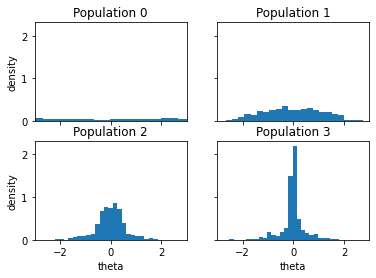

In [ ]:
# @title Run ABC-PRC for the example with standard distance function { vertical-output: true}
N = 1000
epsilons = [2, 0.5, 0.025]

thetas, theta_hist = ABC_PRC(N, epsilons, mu_1, calc_distance)

visualize_results(theta_hist)

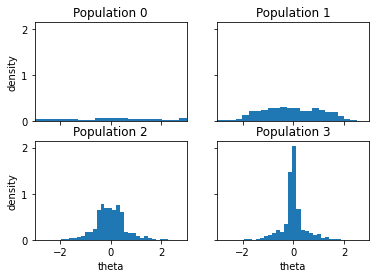

In [ ]:
# @title Run ABC-PRC for the example with alternative distance function { vertical-output: true}
N = 1000
epsilons = [2, 0.5, 0.025]

thetas, theta_hist = ABC_PRC(N, epsilons, mu_1, calc_distanceV2)

visualize_results(theta_hist)

# ABC for lattice models

In the following, we want to apply the ABC framework to estimating the parameters of stochastic lattice models. As an example, we consider a [probabilistic cellular automaton (PCA) for the diffusive spread of a news item](https://colab.research.google.com/drive/1xTxLeSW2BhSIMQAHUlYq8GhUafw7b85F#scrollTo=5fnWUde_LIOo).

Using the [PCA framework](https://link.springer.com/book/10.1007/978-3-319-65558-1), we define:

- The Graph $G$ to be a 2D lattice of $(K,K)$ regular cells
- The Alphabet $S:= \{0,1\}$
- The neighborhood $V_k$ of cell $k$ is the square Moore neighborhood with distance 1

The probability of reaching a configuration $\sigma \in S^{K\times K}$ from a current configuration $\mu \in S^{K\times K}$ is:

$$P(\sigma | \mu) = \prod_{k \in G} p(\sigma_k|\mu_{V_k})$$

Where we define $p(\sigma_k|\mu_{V_k})$, the probability of cell $k$ transitioning to state $\sigma_k$ given the state of its' neighborhood $\mu_{V_k}$ as:

$$p(\sigma_k|\mu_{V_k}) = \begin{pmatrix}
1 & 1-(1-\beta)^{N_k(n)} \\
0 & (1-\beta)^{N_k(n)}
\end{pmatrix}$$

The probability matrix represents, that once a person is aware of the news, they stay aware ($p_{11} = 1$, $p_{21}=0$). The probability, with which an uninformed person stays uninformed at time $n+1$ depends on the amount of local neighbors that are informed at time $n$, $N_k(n)$. Given a rate of spread $\beta$ (the diffusion coefficient), the probability to stay unaware is $p_{22}= (1-\beta)^{N_k(n)}$. Conversely, the probability that the news spread to cell $k$ is $p_{21} = 1 - p_{22} = 1-(1-\beta)^{N_k(n)}$.

In [3]:
# @title define visualization helpers

def visualize_sequence(sequence, framerate):
  for idx, state in enumerate(sequence):
    display.display(plt.gcf())
    plt.imshow(state, cmap='Greys',  interpolation='nearest', vmin=0, vmax=1)
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    display.clear_output(wait=True)
    time.sleep(framerate)

def visualize_transition(transition):
  """
  Visualize a transition

  transition (np.ndarray): numpy matrix of shape (2, grid_height, grid_width)
  """
  fig, axs = plt.subplots(1, 2, figsize=(3,3))
  for stateIdx, state in enumerate(transition):
    axs[stateIdx].imshow(state, cmap='Greys',  interpolation='nearest', vmin=0, vmax=1)
    axs[stateIdx].get_xaxis().set_visible(False)
    axs[stateIdx].get_yaxis().set_visible(False)


In [4]:
# @title define model helpers
def periodic_padding(image, padding=1):
    '''
    Create a periodic padding (wrap) around an image stack, to emulate periodic boundary conditions
    Adapted from https://github.com/tensorflow/tensorflow/issues/956
    
    If the image is 3-dimensional (like an image batch), padding occurs along the last two axes
    '''
    if len(image.shape)==2:
        upper_pad = image[-padding:,:]
        lower_pad = image[:padding,:]

        partial_image = np.concatenate([upper_pad, image, lower_pad], axis=0)

        left_pad = partial_image[:,-padding:]
        right_pad = partial_image[:,:padding]

        padded_image = np.concatenate([left_pad, partial_image, right_pad], axis=1)
        
    elif len(image.shape)==3:
        upper_pad = image[:,-padding:,:]
        lower_pad = image[:,:padding,:]

        partial_image = np.concatenate([upper_pad, image, lower_pad], axis=1)

        left_pad = partial_image[:,:,-padding:]
        right_pad = partial_image[:,:,:padding]

        padded_image = np.concatenate([left_pad, partial_image, right_pad], axis=2)
        
        
    else:
        assert True, "Input data shape not understood."
    
    return padded_image

def risk_convolution2D(batch):
  """
  Use a filter of shape
  | 1  1  1
  | 1  0  1
  | 1  1  1
  and apply it to the periodically padded state of the grid.
  The result will give the number of infected neighbors at each
  state.
  """
  kernel = jnp.ones((1,1,3,3))
  kernel = kernel.at[:,:,1,1].set(0)
  padded_grid = periodic_padding(batch)
  expanded = jnp.expand_dims(padded_grid, axis=-1)
  transposed = jnp.transpose(expanded, (0,3,1,2))

  return lax.conv(
      transposed[:,:,:],  # lhs = NCHW image tensor
      kernel,  # rhs = OIHW conv kernel tensor
      (1, 1),  # window strides
      "VALID"
  )

# @title Spread Likelihood
def calculate_spread_likelihood(batch, beta):
  """
  calculates the likelihood of each cell in the batch transitioning to an
  activated state at the next time step:
  1-(1-ß)^N_k(n)
  """
  risk_conv = risk_convolution2D(batch).squeeze(1)
  return (1 - (1 - beta)**risk_conv) 

In [5]:
# @title define general helpers
def chop_and_shuffle_data(sequences, shuffle=True):
  """
  Chop the training data into a set of state transitions and shuffle the resulting set.

  sequences (np.ndarray): matrix of shape (n_sequences, steps_per_seq, grid_height, grid_width)
  """
  n_sequences, steps_per_seq, grid_height, grid_width = sequences.shape
  # each transition consists of 2 states
  indexer = np.arange(2)[None, :] + np.arange(steps_per_seq-1)[:, None]
  chopped_set = np.zeros([(steps_per_seq-1)*n_sequences, 2, grid_height, grid_width])
  for idx,sequence in enumerate(sequences):
    start_idx = idx*(steps_per_seq-1)
    chopped_set[start_idx:start_idx+steps_per_seq-1, :,:,:] = sequence[indexer]
  if shuffle:
    np.random.shuffle(chopped_set) 
  return chopped_set

# @title Heaviside approx.
def heaviside(x,k):
  return 1 / (1 + jnp.exp(-2*k*x))

# ----------- test the chopping function ---------------
test_data = np.arange(24).reshape(2,3,2,2)
n_sequences, steps_per_seq, grid_height, grid_width = test_data.shape
chopped = chop_and_shuffle_data(test_data, shuffle=False)
assert chopped.shape == (n_sequences*(steps_per_seq-1), 2, grid_height, grid_width)
assert np.all(chopped[0,0] == np.arange(4).reshape(2,2))
assert np.all(chopped[0,1] == (np.arange(4)+4).reshape(2,2))
assert np.all(chopped[1,0] == (np.arange(4)+4).reshape(2,2))
assert np.all(chopped[1,1] == (np.arange(4)+8).reshape(2,2)) 

In [44]:
# @title define the PCA class
# @title News spread PCA
class News_Spread_PCA():
  """
  Represents a PCA model for the diffusive spread of a news item through
  a population.

  size (int): The size of the square grid (height & width).
  batch_size (int): The amount of PCA grids to initialize.
  beta (float): The diffusion coefficient of the model
  """
  def __init__(self, size:int,batch_size:int,beta:float) -> None:
    self.size = size
    self.batch_size = batch_size
    self.grids = np.zeros((batch_size, size, size))
    self.grids[:, size//2, size//2] = 1
    self.beta = beta

  def visualize_surface(self, idx:int) -> None:
    """
    Produce a plot of the current state of the PCA at index <idx> in the batch.
    """
    plt.imshow(self.grids[idx], cmap='Greys',  interpolation='nearest')
  
  def visualize_batch(self) -> None:
    """
    Produce a plot of all current grid states.
    """
    fig, axs = plt.subplots(1, self.batch_size, figsize=(3,3))
    for gridIdx, grid in enumerate(self.grids):
      axs[gridIdx].imshow(grid, cmap='Greys',  interpolation='nearest', vmin=0, vmax=1)
      axs[gridIdx].get_xaxis().set_visible(False)
      axs[gridIdx].get_yaxis().set_visible(False)

  def evolve(self) -> np.ndarray:
    """
    Run a simulation step for each of the PCAs in the batch.
    """
    healthy_mask = self.grids == 0

    likelihoods = calculate_spread_likelihood(self.grids, self.beta)
    infection_update = np.random.rand(*self.grids.shape) <=  likelihoods * healthy_mask 
    self.grids += infection_update.astype(int)

    return self.grids
      
  def run(self, steps=100):
    """
    Run <steps> consecutive simulation steps of the grids. Keeps track of the history
    of states.
    """
    states = [self.grids.copy()]
    for i in range(steps):
      self.evolve()
      states.append(self.grids.copy())
    return np.array(states)

def model(grids:np.ndarray, beta:float) -> np.ndarray:
  healthy_mask = grids == 0

  likelihoods = calculate_spread_likelihood(grids, beta)
  infection_update = np.random.rand(*grids.shape) <=  likelihoods * healthy_mask 
  return grids + infection_update.astype(int)

In [24]:
# @title set PCA parameters
grid_size = 9 #@param {type:"number"}
num_sequences = 100 #@param {type:"number"}
steps_per_sequence = 20 #@param {type: "number"}
beta = 0.08 #@param {type:"slider", min:0, max:1, step:0.01}

# @markdown ---
# @markdown parameters for the PCA visualization

frame_speed = 0.1 # @param {type:"slider", min:0.1, max:2, step:0.01}

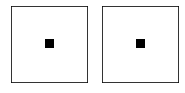

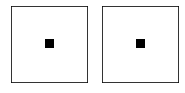

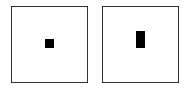

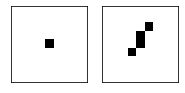

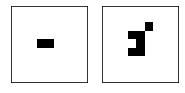

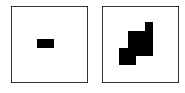

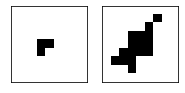

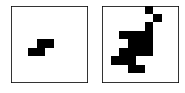

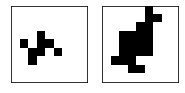

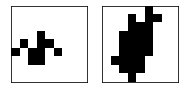

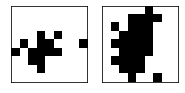

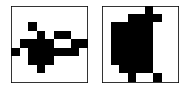

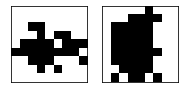

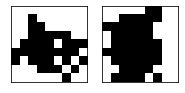

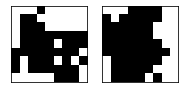

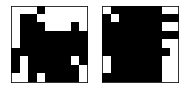

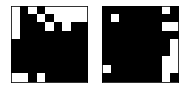

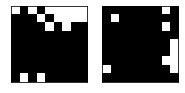

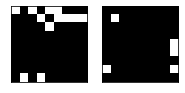

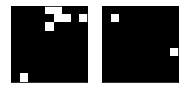

In [25]:
# @title run visualization {vertical-output: true}
grids = News_Spread_PCA(grid_size,2,beta)
for i in range(steps_per_sequence):
  grids.visualize_batch()
  display.display(plt.gcf())
  current = grids.evolve()
  display.clear_output(wait=True)
  time.sleep(frame_speed)

(1900, 2, 9, 9)


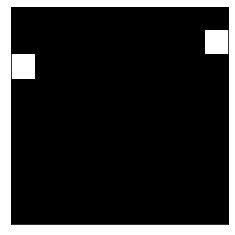

In [26]:
# @title generate dataset
sequences = np.zeros((num_sequences, steps_per_sequence, grid_size, grid_size))
batch = News_Spread_PCA(grid_size,num_sequences,beta)

for i in range(steps_per_sequence):
  sequences[:,i,:,:] = batch.grids[:,:,:]
  batch.evolve()
np.save("./sequence_data", sequences)
visualize_sequence(sequences[np.random.randint(0,num_sequences)], framerate=0.1)
dataset = chop_and_shuffle_data(sequences)
np.save("./dataset", dataset)
print(dataset.shape)

## Defining a set of summary statistics for the PCA

In order to perform PCA, we need to define a set of summary statistics $S(.)$ for the samples produced by the PCA model. Here, we have to make a few choices that will impact the performance of the ABC algorithms.

Our dataset $D = \{x_i, y_i\}_{i=1}^N$ consists of $N$ pairs of grid states. Each pair represents the transition of a grid from a state $x_i$ at a time step $t$ to a state $y_i$ at time step $t+1$. The PCA model takes as input a grid state, simulates a time step for it, and returns the resulting state.

**1. Count the number of newly activated cells**

Our first summary statistic can be to simply count the number of cells transitioning from $x_{ij}^{(n)}= 0$ to $y_{ij}^{(n)}= 1$ for $n=1,\dots,N$.

**2. Collect the indices of the newly activated cells**

The second possible statistic is a collection of the indices of all cells that have changed state between $x_{ij}$ and $y_{ij}$. This allows e.g. to define the distance function as a pixel-wise loss function. 



In [37]:
# @title define summary statistics functions
def S1(X:np.ndarray, Y:np.ndarray) -> float:
  return jnp.sum((1-X)*Y, axis=(-1,-2))

def S2(X:np.ndarray, Y:np.ndarray) -> float:
  return (1-X)*Y

## Defining the distance function 

In order to perform ABC, we need to define a distance function $\rho(S(x_{sim}), S(x_{obs}))$ based on the summary statistics $S(.)$. 

**1. mean squared difference in newly activated cells**

**2. Sum of pixel-wise losses**

In [81]:
# @title define distance functions
def calc_distance_V1(Y_sim:np.ndarray, Y_obs:np.ndarray) -> float:
  # get statistics of the simulated set
  s_sim = S1(Y_sim)
  print(s_sim)
  # get statistics of the observed set
  s_obs = S1(Y_obs)
  print(s_obs)
  # calculate the mean difference
  return jnp.mean(jnp.square(s_sim - s_obs))

def calc_distance_V2(Y_sim:np.ndarray, Y_obs:np.ndarray) -> float:
  # get statistics of the simulated set
  s_sim = S1(Y_sim)
  # get statistics of the observed set
  s_obs = S1(Y_obs)
  # calculate the mean ratio
  return (1 - jnp.mean(s_sim / s_obs))**2

In [60]:
X = dataset[:,0]
Y_obs = dataset[:,1]
Y_sim = model(X, 0.8)
calc_distance_V1(Y_sim, Y_obs)

1584.0
1868.0


DeviceArray(80656., dtype=float32)

In [75]:
X = dataset[:,0]
Y_obs = dataset[:,1]
Y_sim = model(X, 0.8)
calc_distance_V2(Y_sim, Y_obs)

1567.0
1868.0


DeviceArray(0.02596446, dtype=float32)

## Estimate $\beta$ via ABC-REJ

We define:

- $\epsilon = 0.005$ 
- $p(\theta) \sim U(0,1)$

In [78]:
# @title define helpers
def sample_from_prior(size:int):
  return np.random.uniform(0,1,size)

In [79]:
# @title define a rejection sampler function
def ABC_REJ(X:np.ndarray, Y_obs:np.ndarray, epsilon:float) -> float:
  num_steps = 1
  beta = None
  while True:
    beta = sample_from_prior(1)
    Y_sim = model(X, beta)
    distance = calc_distance_V2(Y_sim, Y_obs)
    if distance <= epsilon:
      break
    else:
      num_steps += 1
  return beta, num_steps

In [85]:
# @title use ABC-REJ to draw approximate samples from the posterior  { vertical-output: true}

samples = []
required_steps = []
X = dataset[:,0]
Y_obs = dataset[:,1]
epsilon = 0.001

# In the paper, 1,000 accepted samples are drawn
for i in tqdm(range(1000)):
  sample, num_steps = ABC_REJ(X, Y_obs, epsilon)
  samples.append(sample)
  required_steps.append(num_steps)

print(f"average # steps for acceptance: {np.mean(required_steps)}")




100%|██████████| 1000/1000 [03:44<00:00,  4.46it/s]

average # steps for acceptance: 10.096


Text(0, 0.5, 'density')

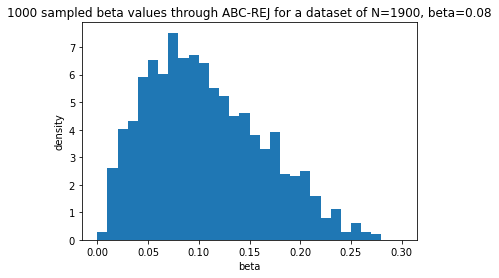

In [113]:
n, bins, _ = plt.hist(np.array(samples).squeeze(-1), density=True, range=(0,0.3), bins=30)
plt.title("1000 sampled beta values through ABC-REJ for a dataset of N=1900, beta=0.08")
plt.xlabel("beta")
plt.ylabel("density")

## Estimate $\beta$ via ABC-MCMC

We define:

- $\epsilon = 0.005$ 
- $\beta_0 = 0.5$
- $q(\theta|\theta_t) \sim \mathcal{N}(\theta_t, 0.15^2)$


In [139]:
# @title define helpers
def sample_from_prior(size:int):
  return np.random.uniform(0,1,size)

# @title Helper Functions
def gaussian_pdf(mu:float, sigma_sq:float) -> Callable:
  def pdf(x:float) -> float:
    return (1/(np.sqrt(2*np.pi)*np.sqrt(sigma_sq)))*np.exp(-(x-mu)**2/(2*sigma_sq))
  return pdf

def q(mu:float, sigma) -> float:
  return np.random.normal(mu, sigma)

def gauss_likelihood(x, y, sigma):
  """
  Calculate the likelihood of x as p(x|y) ~ N(y|sigma_sq)
  """
  pdf = gaussian_pdf(y, sigma)
  return pdf(x)

def calc_alpha(beta_star:float, beta:float, epsilon:float, dist:float, sigma:float) -> float:
  if dist <= epsilon:
    return min([1,gauss_likelihood(beta, beta_star, sigma)/gauss_likelihood(beta_star, beta, sigma)])
  else:
    return 0

In [140]:
# @title Define ABC-MCMC
def ABC_MCMC(X:np.ndarray, Y_obs:np.ndarray, N:int, epsilon:float, beta:float, proposal_sigma:float) -> List[float]:
  betas = [beta]
  for i in tqdm(range(N)):
    beta_star = q(beta, proposal_sigma)
    Y_sim = model(X, beta_star)
    dist = calc_distanceV2(Y_sim, Y_obs)
    alpha = calc_alpha(beta_star, beta, epsilon, dist, proposal_sigma)
    if random.random() <= alpha:
      beta = beta_star
    thetas.append(beta)
  return thetas